# Estimating water consumption of irrigated agriculture in the Limpopo River Basin (LRB)

* **Products used:**
[irrigated_areas_limpopo](https://odc-explorer.digitaltwins.demos-only.iwmi.org/products/irrigated_areas_limpopo),
[WaPOR](https://data.apps.fao.org/wapor/?lang=en)


## Background
The Limpopo River Basin, spanning four countries in southern Africa, at times faces extreme water scarcity. For communities that rely on agriculture in the basin, the efficient use of water is essential. One of our key projects in CGIAR involves developing a [Digital Twin (DT)](https://www.iwmi.org/blogs/can-digital-twins-help-river-basin-management-in-developing-countries/) of the Limpopo River Basin to support better decision-making for managing water in the region. A digital twin is a virtual representation of a physical object or system. The CGIAR Digital Twin initiative creates dynamic virtual models that combine real-time data, AI, and simulations to improve decision-making.   A crucial component of this digital twin is tracking irrigated areas using publicly available satellite data to understand in near real-time where water is being used, how much is being used, and how these patterns change over time. More details on the method developed for mapping irrigated agriculture in the LRB and its water consumption can be found here: https://hdl.handle.net/10568/155296

## Description
This notebook describes how to calculate area covered by irrigated agriculture and subsequently estimate its water consumption for a specific region within the LRB. The steps below were followed:

1. Select a area of interest within the LRB.
2. Download and load irrigated area and the Actual EvapoTranspiration and Interception (National - Annual - 100m) (L2-AETI-M) product of WaPOR datasets.
3. Reproject the two data.
4. Polygonize the irrigated area data and extract mean ET (L2-AETI-M) value for each polygon.
3. Calculate water consumption by getting the sum of all the mean values.

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Install packages" cell.

### Install packages

In [1]:
pip install pystac_client odc-stac wapordl==0.9 xvec rioxarray GDAL datacube --quiet

### Load packages


In [2]:
%matplotlib inline

import os
import datetime
import matplotlib.pyplot as plt
import rasterio.features
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rio
import xvec
import pystac_client
import datacube
import collections
import requests

from osgeo import gdalnumeric, gdal
from odc.stac import configure_rio, stac_load
from datacube.utils.masking import mask_invalid_data
from shapely.geometry import LineString, MultiLineString, mapping, shape
from wapordl import wapor_map

### Set some options for connecting to AWS



IWMI data is stored on S3 in Cape Town, Africa. To load the data, we must configure rasterio with the appropriate AWS S3 endpoint. This can be done with the odc.stac.configure_rio function. Documentation for this function is available at   [https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.configure_rio.html#odc.stac.configure_ri]

In [3]:
os.environ['AWS_S3_ENDPOINT'] = 's3.af-south-1.amazonaws.com'
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'
os.environ['AWS_DEFAULT_REGION'] = 'af-south-1'
os.environ['AWS Access Key ID'] = ''
print(os.getenv('AWS_S3_ENDPOINT'))

s3.af-south-1.amazonaws.com


### Analysis parameters



this anaysis  needs data about the location(lat,lon) and the interested time period to start the analysis. additionallly the user can change the buffer if necessary. that may help to increase ot decrease the area of interest.

In [4]:
lat, lon = -24.5726, 27.2373  #enter the latitude and longitude of your location within the Limpopo River Basin
buffer = 0.01  #how big the area around your location
start_date = "2024-06-01"  # Set your own start date
end_date = "2024-06-30"  # Set your own end date

## Select location
The study area/bounding box is to set a central latitude and longitude coordinate pair, (central_lat, central_lon) and the buffer distance selecetd in all direction from center. Together, these parameters specify a square study area

In [5]:
#join lat, lon, buffer to get bounding box
lon_range = (lon - buffer, lon + buffer)
lat_range = (lat + buffer, lat - buffer)

bbox = [lon_range[0], lat_range[0], lon_range[1], lat_range[1]]

## Download and load irrigated area and WaPOR data

### Download and load irrigated area

This step will connect to IWMI stac API. The collections will specify the product name that is required to be downloaded. stac.load() requires the product name, crs and bounding box details. by default the crs is  WGS84/EPSG:4326. If the coordinates are in a different coordinate system, the crs parameter can be changed.

### Calculation of irrigated area
This function calculates the total irrigated area (in hectares) between two dates using a classified raster file named which is downloaded above. It loads the raster as a NumPy array, counts the number of pixels with a value of 1 (representing irrigated land), multiplies this count by the known area of a single pixel (100 m²), and converts the result to hectares by dividing by 10,000.

In [6]:
# Set the URL of the STAC catalog you wish to query
url = 'https://odc-explorer.digitaltwins.demos-only.iwmi.org/stac' ## follow this link to explore catalog

# Initialize a STAC client to interact with the specified STAC catalog
catalog = pystac_client.Client.open(url)

# Specify the collections to retrieve
collections = ['irrigated_areas_limpopo']

# Build a query with the previously set parameters to search the STAC catalog
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Fetch the items
items = list(query.items())

items   #make an item is output

[<Item id=771ef23c-5050-4da0-9cbb-bcf078ff9e4b>]

In [7]:
# Load the irrigated area for specified parameter values

crs = "EPSG:4326"# can be changed if needed

ds = stac_load(
    items,
    crs=crs,
    chunks={},
    bbox=bbox,
)

ds

<xarray.Dataset> Size: 603kB
Dimensions:      (latitude: 224, longitude: 223, time: 1)
Coordinates:
  * latitude     (latitude) float64 2kB -24.56 -24.56 -24.56 ... -24.58 -24.58
  * longitude    (longitude) float64 2kB 27.23 27.23 27.23 ... 27.25 27.25 27.25
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 8B 2024-06-30
Data variables:
    map          (time, latitude, longitude) float32 200kB dask.array<chunksize=(1, 224, 223), meta=np.ndarray>
    prob         (time, latitude, longitude) float32 200kB dask.array<chunksize=(1, 224, 223), meta=np.ndarray>
    filtered     (time, latitude, longitude) float32 200kB dask.array<chunksize=(1, 224, 223), meta=np.ndarray>

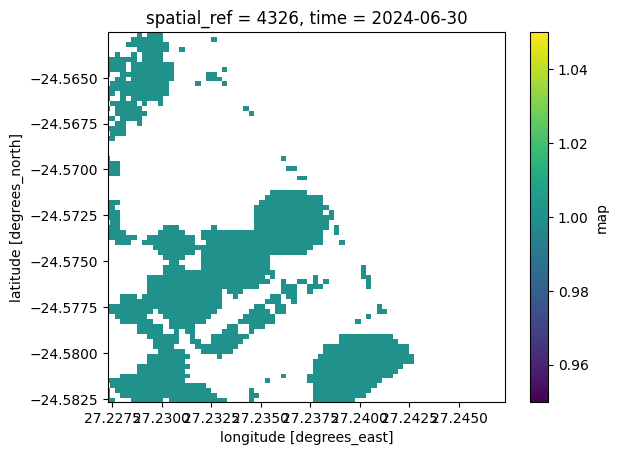

In [8]:
### Visualize irrigated areas for a single date
ds['map'].sel(time= end_date, method='nearest').compute().plot() # we chose here the "map" measurement. Other measurements include "filtered" and "prob"

In [9]:
### Download irrigated area data
irr_dataset = ds['map'].sel(time= end_date, method='nearest').compute()   ## Set your own data
irr_dataset.rio.to_raster(os.getcwd() + "/" + "irrigated_" + end_date + ".tif")

In [10]:
### Calculate area coverage of irrigated agriculture**

area_per_pixel = 100  # area of a single pixel

raster_file = gdalnumeric.LoadFile(os.getcwd() + "/" + "irrigated_" + end_date + ".tif")
pixel_count = (raster_file == 1).sum()  ## get the sum of all the pixels

area_ha = pixel_count * area_per_pixel / 10000  ##pixel_count * area_per_pixel
print('The area of the irrigated field between {} and {} is {} ha: '.format(start_date, end_date, area_ha))

The area of the irrigated field between 2024-06-01 and 2024-06-30 is 106.58 ha: 


### Download and load WaPOR area

WaPOR (Water Productivity through Open access of Remotely sensed derived data) is a dataset developed by FAO (Food and Agriculture Organization of the UN) to monitor water productivity, agriculture, and irrigation performance across Africa and the Near East.

Digital Earth Africa (DE Africa) provides functions for free, analysis-ready access to WaPOR data for the African continent.In this analysis "L2-AETI-M" is used from DE Africa stac as source of wapor data.the data is downloaded in .tiff format for the specific region selected.

In [11]:
BASE_URL = "https://data.apps.fao.org/gismgr/api/v2/catalog/workspaces/WAPOR-3/mapsets"
import collections

def get_WaPORv3_info(url: str, info: str | list[str]) -> pd.DataFrame:

    if isinstance(info, str):
        info = [info]
    elif isinstance(info, list):
        info = [str(i) for i in info]
    else:
        raise TypeError("'info' must be a list or string.")

    data = {"links": [{"rel": "next", "href": url}]}

    output_dict = collections.defaultdict(list)
    while "next" in [x["rel"] for x in data["links"]]:
        url_ = [x["href"] for x in data["links"] if x["rel"] == "next"][0]
        response = requests.get(url_)
        response.raise_for_status()
        data = response.json()["response"]
        for item in data["items"]:
            if info == ["all"]:
                for key in list(item.keys()):
                    output_dict[key].append(item[key])
            else:
                for key in info:
                    output_dict[key].append(item[key])

    output_df = pd.DataFrame(output_dict)

    if "code" in output_df.columns:
        output_df.sort_values("code", inplace=True)
        output_df.reset_index(drop=True, inplace=True)
    return output_df


def get_all_WaPORv3_mapsets() -> pd.DataFrame:
    """
    List all the available WaPOR v3 mapset codes and descriptions.

    Returns
    -------
    pd.DataFrame
        A table of all the available WaPOR v3 mapset codes and descriptions.
    """
    output_df = get_WaPORv3_info(url=BASE_URL, info=["code", "caption"])
    output_df = output_df.rename(columns={"code": "Mapset Code", "caption": "Mapset Description"})

    return output_df

In [12]:
get_all_WaPORv3_mapsets() #Get the list of the products of Wapor. For water water consumption, we are going to use L2-AETI-M

,Mapset Code,Mapset Description
0,L1-AETI-A,Actual EvapoTranspiration and Interception (Gl...
1,L1-AETI-D,Actual EvapoTranspiration and Interception (Gl...
2,L1-AETI-M,Actual EvapoTranspiration and Interception (Gl...
3,L1-E-A,Evaporation (Global - Annual - 300m)
4,L1-E-D,Evaporation (Global - Dekadal - 300m)
5,L1-GBWP-A,Gross biomass water productivity (Annual - 300m)
6,L1-I-A,Interception (Global - Annual - 300m)
7,L1-I-D,Interception (Global - Dekadal - 300m)
8,L1-NBWP-A,Net biomass water productivity (Annual - 300m)
9,L1-NPP-D,Net Primary Production (Global - Dekadal - 300m)


In [13]:
# Set argument values for the downloading wapor data
region =  [lon_range[0], lat_range[1], lon_range[1], lat_range[0]]
folder = os.getcwd() # stored in current wonking directory. Change to your own directory
variable = "L2-AETI-M" # Product
period = [start_date, end_date] # period to load

In [14]:
# Download the WaPOR for specified paramater values
aeti = wapor_map(region, variable, period, folder, extension = '.tif')

In [15]:
# Open the dataset with rioxarray to enable geospatial operations
aeti = rio.open_rasterio("bb_" + variable + "_NONE_none.tif")

In [16]:
# load the WaPor data
aeti

<xarray.DataArray (band: 1, y: 21, x: 22)> Size: 924B
[462 values with dtype=int16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 176B 27.23 27.23 27.23 27.23 ... 27.25 27.25 27.25
  * y            (y) float64 168B -24.56 -24.56 -24.56 ... -24.58 -24.58 -24.58
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:   Area
    end_date:        2024-06-30
    long_name:       Actual EvapoTranspiration and Interception
    number_of_days:  30
    overview:        NONE
    start_date:      2024-06-01
    units:           mm/month
    _FillValue:      -9999
    scale_factor:    0.1
    add_offset:      0.0

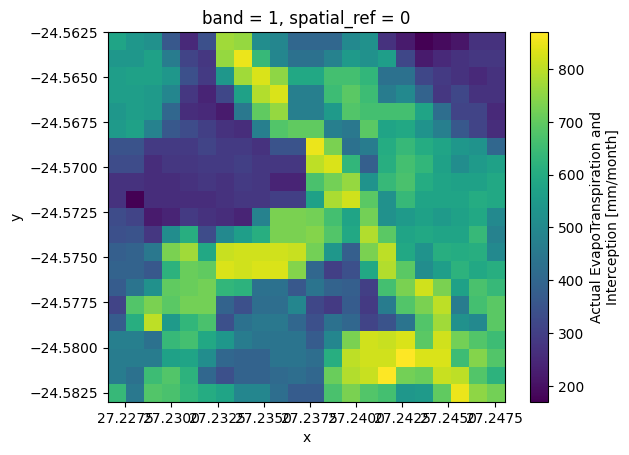

In [17]:
# Visualize the wapor data
aeti.plot()

## Reproject wapor data to the match the spatial resolution of the irrigated area data

This step will verify if irrigated and wapor data have the same projection.if not reprojection will be done followed by resampling and null data removal.

In [18]:
## Verify if irrigated and wapor data have the same projection
aeti.geobox == irr_dataset.geobox

<ipython-input-18-8f8e56ab48eb>:2: DeprecationWarning: Geobox extraction logic has moved to odc-geo and the .geobox property is now deprecated.Please access via .odc.geobox instead.
  aeti.geobox == irr_dataset.geobox


False

In [19]:
# Reproject data
aeti_reprojected = aeti.odc.reproject(how=irr_dataset.odc.geobox, resampling="average")
# Set nodata to `NaN`
aeti_reprojected = mask_invalid_data(aeti_reprojected)

In [20]:
## Verify again if irrigated and wapor data have the same projection
aeti_reprojected.geobox == irr_dataset.geobox

<ipython-input-20-0af2ef02e43e>:2: DeprecationWarning: Geobox extraction logic has moved to odc-geo and the .geobox property is now deprecated.Please access via .odc.geobox instead.
  aeti_reprojected.geobox == irr_dataset.geobox


True

## Polygonize the irrigated area data and extract mean ET value for each polygon

This code identifies irrigated areas from a raster dataset by selecting pixels with a value of 1, then converts these irrigated pixels into vector polygons using xr_vectorize. It then computes the mean Actual Evapotranspiration (ET) for each polygon from a reprojected ET raster (aeti_reprojected) using zonal statistics based on latitude and longitude coordinates.

The resulting ET values are extracted and converted into a pandas DataFrame (df_et), where each row represents a polygon with its corresponding mean ET value. This workflow is useful for evaluating water use in irrigated regions, enabling spatial analysis of evapotranspiration patterns using datasets such as WaPOR.

In [21]:
def add_geobox(ds, crs=None):

    # If a CRS is not found, use custom provided CRS
    if ds.odc.crs is None and crs is not None:
        ds = ds.odc.assign_crs(crs)
    elif ds.odc.crs is None and crs is None:
        raise ValueError(
            "Unable to determine `ds`'s coordinate "
            "reference system (CRS). Please provide a "
            "CRS using the `crs` parameter "
            "(e.g. `crs='EPSG:3577'`)."
        )

    return ds

def xr_vectorize(
    da,
    attribute_col=None,
    crs=None,
    dtype="float32",
    output_path=None,
    verbose=True,
    **rasterio_kwargs,
):

    # Add GeoBox and odc.* accessor to array using `odc-geo`
    da = add_geobox(da, crs)

    # Run the vectorizing function
    vectors = rasterio.features.shapes(
        source=da.data.astype(dtype), transform=da.odc.transform, **rasterio_kwargs
    )

    # Convert the generator into a list
    vectors = list(vectors)

    # Extract the polygon coordinates and values from the list
    polygons = [polygon for polygon, value in vectors]
    values = [value for polygon, value in vectors]

    # Convert polygon coordinates into polygon shapes
    polygons = [shape(polygon) for polygon in polygons]

    # Create a geopandas dataframe populated with the polygon shapes
    attribute_name = attribute_col if attribute_col is not None else "attribute"
    gdf = gpd.GeoDataFrame(data={attribute_name: values}, geometry=polygons, crs=da.odc.crs)

    # If a file path is supplied, export to file
    if output_path is not None:
        if verbose:
            print(f"Exporting vector data to {output_path}")
        gdf.to_file(output_path)

    return gdf

In [22]:
#Polygonize irrigated areas
gdf = xr_vectorize(irr_dataset,
                  mask= irr_dataset.values==1)
gdf.head()

,attribute,geometry
0,1.0,"POLYGON ((27.23249 -24.56278, 27.23249 -24.563..."
1,1.0,"POLYGON ((27.23088 -24.56332, 27.23088 -24.563..."
2,1.0,"POLYGON ((27.23303 -24.5644, 27.23303 -24.5646..."
3,1.0,"POLYGON ((27.23222 -24.56467, 27.23222 -24.565..."
4,1.0,"POLYGON ((27.23169 -24.56521, 27.23169 -24.565..."


In [23]:
# extract mean ET value for each polygon
et_extracted = aeti_reprojected.xvec.zonal_stats(gdf.geometry, "longitude", "latitude")  # "mean" is the default spatial aggregation statistic method

In [24]:
df_et = pd.DataFrame(et_extracted.values, columns=['mean_et']) #Convert the resulting DataArray to dataframe
df_et.head()

,mean_et
0,770.000000
1,275.666656
2,583.333313
3,466.933319
4,281.000000


## Calculate water consumption for the whole irrigated area

*mean_et:* Represents the mean evapotranspiration value per polygon in millimeters (mm).

*0.1:* A scale factor used to correct or normalize the ET values if they were originally scaled (common in satellite datasets).

*0.001:* Converts millimeters (mm) to meters (m).

*100:* Represents the pixel area in square meters (m²) — likely assuming each pixel is 10m x 10m (100 m²).

The result is an estimate of water volume (in m³) consumed by evapotranspiration in each polygon.



In [25]:
## Add a column, multiply each row value with scale factor (0.1), then by 0.001 (to convert m3), then by the pixel area (100), and sum all the row values to get the total ET value of the whole irrigated area
df_et['water_consumption'] = df_et['mean_et'] * 0.1 * 0.001 * 100
sum_et = df_et['water_consumption'].sum()

print('The water consumption of the irrigated field between {} and {} is : {} m3'.format(start_date, end_date, sum_et))

The water consumption of the irrigated field between 2024-06-01 and 2024-06-30 is : 158.29751586914062 m3


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

## References

1.   Garcia Andarcia, M., Dickens, C., Silva, P., Matheswaran, K., & Koo, J. (2024). Digital Twin for management of water resources in the Limpopo River Basin: a concept. Colombo, Sri Lanka: International Water Management Institute (IWMI). CGIAR Initiative on Digital Innovation. 4p.
2.   Afham, Abdul; Silva, Paulo; Ghosh, Surajit; Kiala, Zolo; Retief, H.; Dickens, Chris; Garcia Andarcia, Mariangel. 2024. Limpopo River Basin Digital Twin Open Data Cube Catalog. Colombo, Sri Lanka: International Water Management Institute (IWMI). CGIAR Initiative on Digital Innovation. 22p.
3.   Kiala, Zolo; Matheswaran, Karthikeyan. 2024. Status of irrigated area in the Limpopo River Basin: July 2024. Colombo, Sri Lanka: International Water Management Institute (IWMI). CGIAR Initiative on Digital Innovation. 5p.

In [26]:
print(datacube.__version__)

1.9.4


**Contributors**

Zolo Kiala <br>
Postdoc researcher <br>
Email: z.kiala@cgiar.org <br>

<br>

Kayathri Vigneswaran <br>
Junior Data Scientist <br>
Email: v.kayathri@cgiar.org <br>

**Last Tested:**

In [27]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-06-05'